In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def get_column_names(s, df):
    cols = df.columns.tolist()
    return list(filter(lambda x: x.startswith(s), cols))

In [3]:
def get_cols(df, cols):
    return df[cols].T.values

In [4]:
# df_votes.json is created in ./df_stacked.ipynb. 
#  Make sure to re-run that whenever we change something, 
#   otherwise we'll be working with stale data in this notebook
df_votes = pd.read_json('df_votes.json')
df_votes_exclude_5 = pd.read_json('df_votes_exclude_5.json')

In [5]:
df = pd.read_json('df_stacked.json')

df_classify = df.query("workflow_name == 'Classify!'")

In [6]:
def pfit(x, y, deg=1):
    'Perform n-th degree polynomial fit to data points (x, y)'
    idx = np.where(~np.isnan(x) & ~np.isnan(y))

    _x = x[idx]
    _y = y[idx]

    xs = np.linspace(np.min(_x), np.max(_x), int(1e4))

    # build polynomial factors, sum them to get each value of y
    #  this could be done more easily using np.polyval, but I didn't know that existed when I wrote this
    p = np.polyfit(_x, _y, deg)[::-1]
    ys = sum([p[i]*xs**i for i in range(len(p))])
    
    return xs, ys

In [7]:
def fit_color(r, g, votes, deg=1):
    'Perform polynomial fit on relation between g-r color and percentage of votes for a given T2 `color` answer'
    idc = np.where(~np.isnan(r) & ~np.isnan(g) & ~np.isnan(votes))

    _g = g[idc]
    _r = r[idc]
    _votes = votes[idc]

    xs = np.linspace(np.min(_g - _r), np.max(_g - _r), int(1e4))

    # build polynomial factors, sum them to get each value of y
    p = np.polyfit(_g - _r, _votes, deg)[::-1]
    ys = sum(
        [ 
            p[i]*xs**i for i in range(len(p)) 
        ]
    )
    
    return xs, ys

## Extract vote percentages per task:

### First print unique answers:

In [8]:
tasks_hardcore = [0, 2, 1, 3, 4, 5, 9]
task_strings = ['T{}'.format(t) for t in tasks_hardcore]

In [9]:
for t in task_strings:
    print(t, df[t].unique().tolist())

T0 ['galaxy', 'group of objects (cluster)', 'something else/empty center']
T2 ['Impossible to say', 'White/blue', None, 'Red/yellow']
T1 ['Fluffy', None, 'Bright']
T3 ['No/Unsure', None, 'Yes, a bright point', 'Yes, a bulge']
T4 ['Distorted/disturbed', 'Elliptical', None, 'Round']
T5 [None, 'Smooth and fuzzy', 'Smooth and dense', 'Clumpy and/or featured']
T9 [None, 'Something else', 'Looks like a small star', 'Scattered light', 'Nothing: background too bright or galaxy too faint']


In [10]:
tasks_hardcore = [0, 2, 1, 3, 4, 5, 9]
task_strings = ['T{}'.format(t) for t in tasks_hardcore]

### Plot task 5 answers (clumpy/fuzzy/dense) vs. concentration

In [11]:
t5cols = get_column_names('T5', df_votes)
print(t5cols)

['T5', 'T5 % smooth and fuzzy', 'T5 % smooth and dense', 'T5 % clumpy and/or featured']


In [12]:
fuzzy, dense, clumpy = t5cols[1:4]
C, fuzzy, dense, clumpy = get_cols(df_votes, ['C', fuzzy, dense, clumpy])

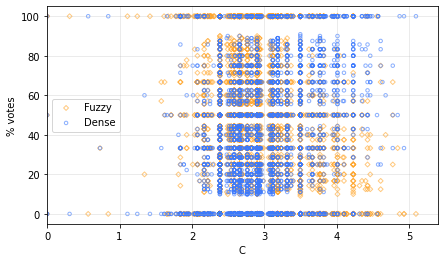

In [13]:
fig, fr = plt.subplots(figsize=(7,4))

fr.scatter(C, fuzzy, s=12, facecolor="none", edgecolor="xkcd:mango", alpha=0.6, marker="D", label='Fuzzy')
fr.scatter(C, dense, s=12, facecolor="none", edgecolor="xkcd:lightish blue", alpha=0.6, label='Dense')
fr.set_xlim(0, max(C)+0.3)
fr.set_ylabel('% votes')
fr.set_xlabel('C')
fr.legend()
fr.grid(alpha=0.3, which='both')
plt.show()

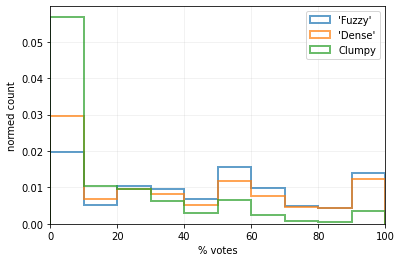

In [14]:
fig, fr = plt.subplots()

kwargs = { "histtype": "step", "lw": 2, "alpha": 0.7, "density": True }
fr.hist(fuzzy, **kwargs, label="'Fuzzy'")
fr.hist(dense, **kwargs, label="'Dense'")
fr.hist(clumpy, **kwargs, label='Clumpy')

fr.set_xlim([0,100])
fr.set_xlabel('% votes')
fr.set_ylabel('normed count')
fr.grid(which='major', alpha=0.2)
fr.legend()
plt.show()


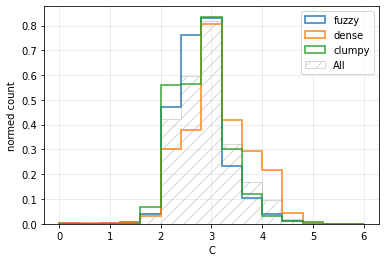

In [15]:
fig, fr = plt.subplots()

labels = ['fuzzy', 'dense', 'clumpy']
for index, i in enumerate(range(1,4)):
    c = df_votes.query("`{}` > 50".format(t5cols[i]))['C']
    fr.hist(c, range=[0, 6], density=True, histtype="step", alpha=0.8, lw=1.8, label=labels[index], bins=15)
    
fr.hist(df_votes['C'], range=[0,6], density=True, histtype='stepfilled', hatch='//', alpha=0.8, label='All',facecolor='None', edgecolor='#ccc', bins=15)
fr.legend()
fr.set_xlabel('C')
fr.set_ylabel('normed count')
fr.grid(alpha=0.3)
plt.show()

## Plot task 1 answers vs. photometric parameters

In [16]:
t1cols = get_column_names('T1', df_votes)
print(t1cols)

['T1', 'T1 % fluffy', 'T1 % bright']


In [17]:
r, g, i, mue_r, bright, fluffy = get_cols(df_votes, ['r', 'g', 'i', 'mue_r', *t1cols[1:]])

### r' [mag] vs. % votes fluffy/bright

In [18]:
# fig, fr = plt.subplots(figsize=(8,5))

# kwargs = { "alpha": 0.6, "s": 9, "facecolor": "none"}

# fr.scatter(r, bright, **kwargs, marker="D", edgecolor="xkcd:lightish blue", label="bright")
# fr.scatter(r, fluffy, **kwargs, marker="v", edgecolor="xkcd:orange", label="fluffy")
# fr.update({
#     'xlabel': r"$r'$",
#     "ylabel": '% votes'
# })
# fr.legend()
# plt.show()

### g'-r' [mag] vs. % votes fluffy/bright

In [19]:
# fig, fr = plt.subplots(figsize=(10, 7))

# kwargs = { "alpha": 0.45, "s": 9, "facecolor": "none"}

# fr.scatter(g-r, bright, **kwargs, marker="D", edgecolor="xkcd:lightish blue", label="bright")
# fr.plot(*fit_color(r,g, bright), label='linear fit (bright)', lw=1, ls='-', c='black')

# fr.scatter(g-r, fluffy, **kwargs, marker="v", edgecolor="xkcd:orange", label="fluffy")
# fr.plot(*fit_color(r,g, fluffy), label='linear fit (fluffy)', lw=2, ls='--', c='black')

# fr.update({
#     'xlabel': r"$g'-r'$",
#     "ylabel": '% votes',
#     "ylim": [-2,102],
#     "title": "Color vs. % votes bright/fluffy"
# })
# fr.legend()
# fr.grid(alpha=0.3)
# plt.show()

## Fluffy/bright vs. surface brightness

In [20]:
fluf = df_votes.query('`T0 % galaxy` > 75').query('`T1 % fluffy` > 75')
bright = df_votes.query('`T0 % galaxy` > 75').query('`T1 % bright` > 75')

# fig, fr = plt.subplots(figsize=(8,6))
# fr.scatter(fluf['g'] - fluf['r'], fluf['mue_r'], label='fluffy', alpha=0.75, s=12)
# fr.scatter(bright['g'] - bright['r'], bright['mue_r'], label='bright', alpha=0.75, s=12)

# fr.update({
#     'xlabel': 'g-r',
#     'ylabel': 'mue_r'
# })
# fr.grid(alpha=0.3)
# fr.legend()

Colored by g-r, which shows that higher fluffy votes occur when the object is redder

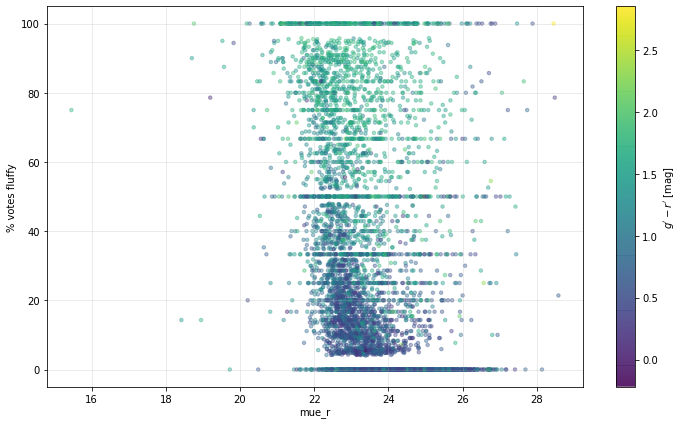

In [21]:
fig, fr = plt.subplots(figsize=(12,7))

sc = fr.scatter(mue_r, fluffy, c=g-r, alpha=0.4, s=12)
cb = fig.colorbar(sc)
cb.solids.set_edgecolor('face')
cb.set_label("$g'-r'$ [mag]")

fr.grid(alpha=0.3)
fr.update({
    'xlabel': 'mue_r',
    'ylabel': "% votes fluffy"
})

plt.savefig('mu vs fluffy votes.png', dpi=450, bbox_inches='tight')
plt.show()

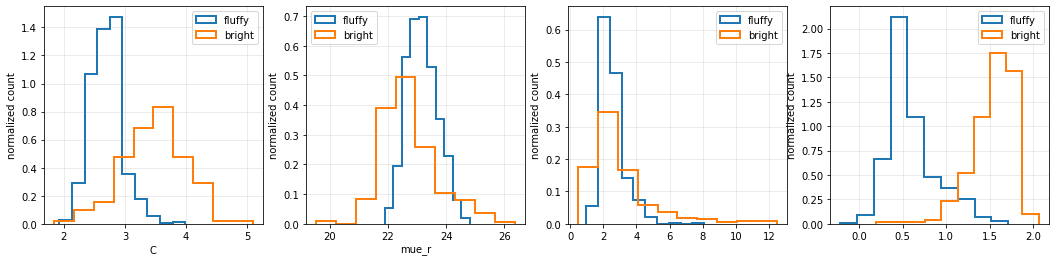

In [22]:
fig, fr = plt.subplots(1,4, figsize=(18,4))

kwargs= { "histtype": "step", "density": True, "lw": 2 }

fr[0].hist(*get_cols(fluf, ['C']), **kwargs, label='fluffy')
fr[0].hist(*get_cols(bright, ['C']), **kwargs, label='bright')

fr[1].hist(*get_cols(fluf, ['mue_r']), **kwargs, label='fluffy')
fr[1].hist(*get_cols(bright, ['mue_r']), **kwargs, label='bright')

fr[2].hist(*get_cols(fluf, ['Reff']), **kwargs, label='fluffy')
fr[2].hist(*get_cols(bright, ['Reff']), **kwargs, label='bright')

g, r = get_cols(fluf, ['g', 'r'])
fr[3].hist(g-r, **kwargs, label='fluffy')
g, r = get_cols(bright, ['g', 'r'])
fr[3].hist(g-r, **kwargs, label='bright')

fr[0].set_xlabel('C')
fr[1].set_xlabel('mue_r')

for i in range(4):
    fr[i].grid(alpha=0.3)
    fr[i].legend()
    fr[i].set_ylabel('normalized count')
    
plt.show()

# Plot task 2 answers vs. color

In [23]:
t2cols = get_column_names('T2', df_votes)

In [24]:
def plot_color_vs_color_votes(d, n=None):
    g, r, w_b, r_y = get_cols(d, ['g', 'r', *t2cols[2:]])

    fig, fr = plt.subplots(1,2, figsize=(10,5), sharey=True)

    kwargs = { "alpha": 0.5, "s": 12, "facecolor": "none" }

    fr[0].scatter(g-r, w_b, **kwargs, marker="D", edgecolor="xkcd:lightish blue", label="data")
    fr[0].plot(*fit_color(r, g, w_b), c='xkcd:lightish blue', lw=2.5, ls='-.', label="linear fit")

    fr[1].scatter(g-r, r_y, **kwargs, marker="v", edgecolor="xkcd:orange", label="data")
    fr[1].plot(*fit_color(r, g, r_y), c='xkcd:orange', lw=2.5, ls='--', label="linear fit")

    for i in range(2):
        fr[i].set_xlabel(r"$g'-r'$ [mag]")

        fr[i].grid(alpha=0.3, which='both')
        fr[i].legend()

    fr[0].set_title('% votes White/blue')
    fr[1].set_title('% votes Red/yellow')
    fr[0].set_ylim(-2, 102)
    fr[0].set_ylabel('% votes')

    fig.tight_layout()
    
    if n:
        plt.savefig('./plots_final/color vs votes - exclude {}.png'.format(n), dpi=450, bbox_inches='tight')
    
    idc = np.where((~d['g'].isnull()) & (~d['r'].isnull()) & (~d['T2 % red/yellow'].isnull()) & (~d['T2 % white/blue'].isnull()))
    return (
        np.corrcoef(g[idc]-r[idc], w_b[idc])[0,1], 
        np.corrcoef(g[idc]-r[idc], r_y[idc])[0,1]
    )


### Plot correlation for 0, 5 and 25 classifications excluded per user:

The two correlations printed are the Pearson correlation for the left and right plot, respectively. We see that as we exclude more classifications per user, the correlation becomes stronger.

We can also plot only the objects that get more than, say, 5 votes for task 2, which would also increase correlation.

Uncomment the following code cells to plot task 2 vote distributions as a function of the $g'-r'$ color of objects.

(-0.7275820669184698, 0.7809517236719219)

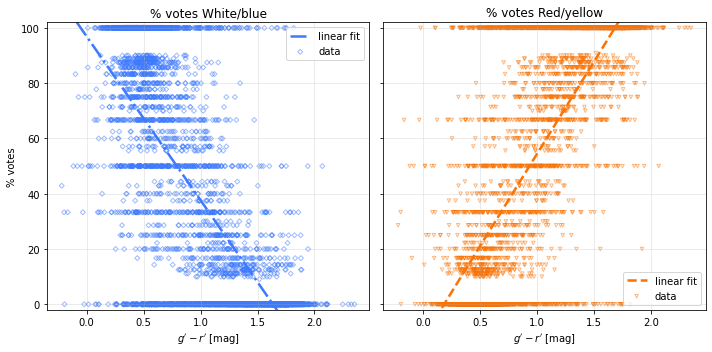

In [30]:
plot_color_vs_color_votes(df_votes, 0)

In [26]:
# plot_color_vs_color_votes(df_votes_exclude_5, 5)

In [27]:
# plot_color_vs_color_votes(pd.read_json('df_votes_exclude_25.json'), 25)

In [28]:
# has_5_t2_votes = df_votes[df_votes.apply(lambda x: sum(x['T2'].values()) >=5, axis=1 )]

In [29]:
# plot_color_vs_color_votes(has_5_t2_votes)

We see that if we only take objects with at least 5 T2 votes, then the correlation is even stronger. Further filtering this by excluding each user's first few classifications would make the correlation even stronger, most likely.